In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
num_classes = 7

In [4]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [9]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((280, 218))
])

#dataset_str = 'cropped_images'
dataset_str = 'cropped_processed_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'

training_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=0)

testing_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=10, shuffle=True, num_workers=0)

In [10]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [11]:
model = model.to(device)

In [12]:
results_dir = 'results/'

In [13]:
import csv
csv_header = ['Classification loss']

csvfile = open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [14]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                    print(
                        f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                    )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 4 / 10 with accuracy 40.00
Got 12 / 20 with accuracy 60.00
Got 20 / 30 with accuracy 66.67
Got 25 / 40 with accuracy 62.50
Got 31 / 50 with accuracy 62.00
Got 41 / 60 with accuracy 68.33
Got 48 / 70 with accuracy 68.57
Got 57 / 80 with accuracy 71.25
Got 66 / 90 with accuracy 73.33
Got 73 / 100 with accuracy 73.00
Got 82 / 110 with accuracy 74.55
Got 90 / 120 with accuracy 75.00
Got 98 / 130 with accuracy 75.38
Got 106 / 140 with accuracy 75.71
Got 113 / 150 with accuracy 75.33
Got 122 / 160 with accuracy 76.25
Got 130 / 170 with accuracy 76.47
Got 136 / 180 with accuracy 75.56
Got 139 / 190 with accuracy 73.16
Got 144 / 196 with accuracy 73.47
----------
Epoch 1/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 32 / 40 with accuracy 80.00
Got 39 / 50 with accuracy 78.00
Got 49 / 60 with accuracy 81.67
Got 57 / 70 with accuracy 81.43
Got 65 / 80 with accuracy 81.25
Got 75 / 90 with accuracy 83.33
Got 85 / 100 with accuracy 85.00
Got 93 / 110 with accuracy 84.55
Got 102 / 120 with accuracy 85.00
Got 110 / 130 with accuracy 84.62
Got 120 / 140 with accuracy 85.71
Got 128 / 150 with accuracy 85.33
Got 136 / 160 with accuracy 85.00
Got 146 / 170 with accuracy 85.88
Got 152 / 180 with accuracy 84.44
Got 160 / 190 with accuracy 84.21
Got 165 / 196 with accuracy 84.18
----------
Epoch 2/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 15 / 20 with accuracy 75.00
Got 24 / 30 with accuracy 80.00
Got 31 / 40 with accuracy 77.50
Got 37 / 50 with accuracy 74.00
Got 45 / 60 with accuracy 75.00
Got 53 / 70 with accuracy 75.71
Got 59 / 80 with accuracy 73.75
Got 67 / 90 with accuracy 74.44
Got 75 / 100 with accuracy 75.00
Got 83 / 110 with accuracy 75.45
Got 92 / 120 with accuracy 76.67
Got 100 / 130 with accuracy 76.92
Got 108 / 140 with accuracy 77.14
Got 118 / 150 with accuracy 78.67
Got 125 / 160 with accuracy 78.12
Got 133 / 170 with accuracy 78.24
Got 139 / 180 with accuracy 77.22
Got 147 / 190 with accuracy 77.37
Got 152 / 196 with accuracy 77.55
----------
Epoch 3/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 26 / 30 with accuracy 86.67
Got 33 / 40 with accuracy 82.50
Got 41 / 50 with accuracy 82.00
Got 44 / 60 with accuracy 73.33
Got 52 / 70 with accuracy 74.29
Got 60 / 80 with accuracy 75.00
Got 69 / 90 with accuracy 76.67
Got 76 / 100 with accuracy 76.00
Got 84 / 110 with accuracy 76.36
Got 93 / 120 with accuracy 77.50
Got 101 / 130 with accuracy 77.69
Got 111 / 140 with accuracy 79.29
Got 119 / 150 with accuracy 79.33
Got 128 / 160 with accuracy 80.00
Got 136 / 170 with accuracy 80.00
Got 146 / 180 with accuracy 81.11
Got 155 / 190 with accuracy 81.58
Got 161 / 196 with accuracy 82.14
----------
Epoch 4/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 18 / 20 with accuracy 90.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 46 / 50 with accuracy 92.00
Got 55 / 60 with accuracy 91.67
Got 64 / 70 with accuracy 91.43
Got 73 / 80 with accuracy 91.25
Got 83 / 90 with accuracy 92.22
Got 93 / 100 with accuracy 93.00
Got 103 / 110 with accuracy 93.64
Got 113 / 120 with accuracy 94.17
Got 122 / 130 with accuracy 93.85
Got 132 / 140 with accuracy 94.29
Got 142 / 150 with accuracy 94.67
Got 152 / 160 with accuracy 95.00
Got 162 / 170 with accuracy 95.29
Got 172 / 180 with accuracy 95.56
Got 180 / 190 with accuracy 94.74
Got 184 / 196 with accuracy 93.88
----------
Epoch 5/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 16 / 20 with accuracy 80.00
Got 26 / 30 with accuracy 86.67
Got 34 / 40 with accuracy 85.00
Got 41 / 50 with accuracy 82.00
Got 49 / 60 with accuracy 81.67
Got 58 / 70 with accuracy 82.86
Got 66 / 80 with accuracy 82.50
Got 73 / 90 with accuracy 81.11
Got 82 / 100 with accuracy 82.00
Got 91 / 110 with accuracy 82.73
Got 100 / 120 with accuracy 83.33
Got 107 / 130 with accuracy 82.31
Got 115 / 140 with accuracy 82.14
Got 123 / 150 with accuracy 82.00
Got 131 / 160 with accuracy 81.88
Got 137 / 170 with accuracy 80.59
Got 145 / 180 with accuracy 80.56
Got 154 / 190 with accuracy 81.05
Got 160 / 196 with accuracy 81.63
----------
Epoch 6/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 17 / 20 with accuracy 85.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 56 / 60 with accuracy 93.33
Got 65 / 70 with accuracy 92.86
Got 73 / 80 with accuracy 91.25
Got 82 / 90 with accuracy 91.11
Got 92 / 100 with accuracy 92.00
Got 102 / 110 with accuracy 92.73
Got 110 / 120 with accuracy 91.67
Got 120 / 130 with accuracy 92.31
Got 128 / 140 with accuracy 91.43
Got 137 / 150 with accuracy 91.33
Got 147 / 160 with accuracy 91.88
Got 155 / 170 with accuracy 91.18
Got 163 / 180 with accuracy 90.56
Got 172 / 190 with accuracy 90.53
Got 178 / 196 with accuracy 90.82
----------
Epoch 7/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 36 / 40 with accuracy 90.00
Got 45 / 50 with accuracy 90.00
Got 52 / 60 with accuracy 86.67
Got 62 / 70 with accuracy 88.57
Got 71 / 80 with accuracy 88.75
Got 79 / 90 with accuracy 87.78
Got 88 / 100 with accuracy 88.00
Got 97 / 110 with accuracy 88.18
Got 106 / 120 with accuracy 88.33
Got 114 / 130 with accuracy 87.69
Got 123 / 140 with accuracy 87.86
Got 130 / 150 with accuracy 86.67
Got 137 / 160 with accuracy 85.62
Got 146 / 170 with accuracy 85.88
Got 154 / 180 with accuracy 85.56
Got 161 / 190 with accuracy 84.74
Got 167 / 196 with accuracy 85.20
----------
Epoch 8/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 36 / 40 with accuracy 90.00
Got 46 / 50 with accuracy 92.00
Got 55 / 60 with accuracy 91.67
Got 63 / 70 with accuracy 90.00
Got 72 / 80 with accuracy 90.00
Got 80 / 90 with accuracy 88.89
Got 90 / 100 with accuracy 90.00
Got 100 / 110 with accuracy 90.91
Got 108 / 120 with accuracy 90.00
Got 117 / 130 with accuracy 90.00
Got 125 / 140 with accuracy 89.29
Got 135 / 150 with accuracy 90.00
Got 145 / 160 with accuracy 90.62
Got 154 / 170 with accuracy 90.59
Got 163 / 180 with accuracy 90.56
Got 173 / 190 with accuracy 91.05
Got 177 / 196 with accuracy 90.31
----------
Epoch 9/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 35 / 40 with accuracy 87.50
Got 43 / 50 with accuracy 86.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 71 / 80 with accuracy 88.75
Got 80 / 90 with accuracy 88.89
Got 88 / 100 with accuracy 88.00
Got 96 / 110 with accuracy 87.27
Got 105 / 120 with accuracy 87.50
Got 114 / 130 with accuracy 87.69
Got 123 / 140 with accuracy 87.86
Got 133 / 150 with accuracy 88.67
Got 143 / 160 with accuracy 89.38
Got 151 / 170 with accuracy 88.82
Got 159 / 180 with accuracy 88.33
Got 167 / 190 with accuracy 87.89
Got 171 / 196 with accuracy 87.24
----------
Epoch 10/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 36 / 40 with accuracy 90.00
Got 44 / 50 with accuracy 88.00
Got 54 / 60 with accuracy 90.00
Got 64 / 70 with accuracy 91.43
Got 73 / 80 with accuracy 91.25
Got 83 / 90 with accuracy 92.22
Got 93 / 100 with accuracy 93.00
Got 100 / 110 with accuracy 90.91
Got 110 / 120 with accuracy 91.67
Got 120 / 130 with accuracy 92.31
Got 129 / 140 with accuracy 92.14
Got 138 / 150 with accuracy 92.00
Got 148 / 160 with accuracy 92.50
Got 158 / 170 with accuracy 92.94
Got 165 / 180 with accuracy 91.67
Got 174 / 190 with accuracy 91.58
Got 180 / 196 with accuracy 91.84
----------
Epoch 11/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 18 / 20 with accuracy 90.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 57 / 60 with accuracy 95.00
Got 66 / 70 with accuracy 94.29
Got 75 / 80 with accuracy 93.75
Got 84 / 90 with accuracy 93.33
Got 94 / 100 with accuracy 94.00
Got 102 / 110 with accuracy 92.73
Got 111 / 120 with accuracy 92.50
Got 120 / 130 with accuracy 92.31
Got 130 / 140 with accuracy 92.86
Got 139 / 150 with accuracy 92.67
Got 149 / 160 with accuracy 93.12
Got 157 / 170 with accuracy 92.35
Got 166 / 180 with accuracy 92.22
Got 176 / 190 with accuracy 92.63
Got 182 / 196 with accuracy 92.86
----------
Epoch 12/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 35 / 40 with accuracy 87.50
Got 43 / 50 with accuracy 86.00
Got 52 / 60 with accuracy 86.67
Got 62 / 70 with accuracy 88.57
Got 71 / 80 with accuracy 88.75
Got 80 / 90 with accuracy 88.89
Got 90 / 100 with accuracy 90.00
Got 99 / 110 with accuracy 90.00
Got 108 / 120 with accuracy 90.00
Got 117 / 130 with accuracy 90.00
Got 125 / 140 with accuracy 89.29
Got 134 / 150 with accuracy 89.33
Got 143 / 160 with accuracy 89.38
Got 153 / 170 with accuracy 90.00
Got 163 / 180 with accuracy 90.56
Got 172 / 190 with accuracy 90.53
Got 177 / 196 with accuracy 90.31
----------
Epoch 13/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 53 / 60 with accuracy 88.33
Got 63 / 70 with accuracy 90.00
Got 71 / 80 with accuracy 88.75
Got 81 / 90 with accuracy 90.00
Got 90 / 100 with accuracy 90.00
Got 100 / 110 with accuracy 90.91
Got 110 / 120 with accuracy 91.67
Got 119 / 130 with accuracy 91.54
Got 129 / 140 with accuracy 92.14
Got 138 / 150 with accuracy 92.00
Got 148 / 160 with accuracy 92.50
Got 158 / 170 with accuracy 92.94
Got 168 / 180 with accuracy 93.33
Got 178 / 190 with accuracy 93.68
Got 184 / 196 with accuracy 93.88
----------
Epoch 14/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 17 / 20 with accuracy 85.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 44 / 50 with accuracy 88.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 72 / 80 with accuracy 90.00
Got 82 / 90 with accuracy 91.11
Got 90 / 100 with accuracy 90.00
Got 99 / 110 with accuracy 90.00
Got 108 / 120 with accuracy 90.00
Got 116 / 130 with accuracy 89.23
Got 125 / 140 with accuracy 89.29
Got 135 / 150 with accuracy 90.00
Got 145 / 160 with accuracy 90.62
Got 154 / 170 with accuracy 90.59
Got 163 / 180 with accuracy 90.56
Got 172 / 190 with accuracy 90.53
Got 178 / 196 with accuracy 90.82
----------
Epoch 15/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 57 / 60 with accuracy 95.00
Got 66 / 70 with accuracy 94.29
Got 76 / 80 with accuracy 95.00
Got 85 / 90 with accuracy 94.44
Got 95 / 100 with accuracy 95.00
Got 104 / 110 with accuracy 94.55
Got 113 / 120 with accuracy 94.17
Got 122 / 130 with accuracy 93.85
Got 131 / 140 with accuracy 93.57
Got 140 / 150 with accuracy 93.33
Got 150 / 160 with accuracy 93.75
Got 159 / 170 with accuracy 93.53
Got 169 / 180 with accuracy 93.89
Got 178 / 190 with accuracy 93.68
Got 184 / 196 with accuracy 93.88
----------
Epoch 16/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 56 / 60 with accuracy 93.33
Got 66 / 70 with accuracy 94.29
Got 75 / 80 with accuracy 93.75
Got 85 / 90 with accuracy 94.44
Got 95 / 100 with accuracy 95.00
Got 105 / 110 with accuracy 95.45
Got 114 / 120 with accuracy 95.00
Got 123 / 130 with accuracy 94.62
Got 131 / 140 with accuracy 93.57
Got 140 / 150 with accuracy 93.33
Got 150 / 160 with accuracy 93.75
Got 159 / 170 with accuracy 93.53
Got 169 / 180 with accuracy 93.89
Got 177 / 190 with accuracy 93.16
Got 183 / 196 with accuracy 93.37
----------
Epoch 17/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 16 / 20 with accuracy 80.00
Got 22 / 30 with accuracy 73.33
Got 32 / 40 with accuracy 80.00
Got 41 / 50 with accuracy 82.00
Got 49 / 60 with accuracy 81.67
Got 59 / 70 with accuracy 84.29
Got 65 / 80 with accuracy 81.25
Got 73 / 90 with accuracy 81.11
Got 81 / 100 with accuracy 81.00
Got 90 / 110 with accuracy 81.82
Got 99 / 120 with accuracy 82.50
Got 104 / 130 with accuracy 80.00
Got 112 / 140 with accuracy 80.00
Got 122 / 150 with accuracy 81.33
Got 131 / 160 with accuracy 81.88
Got 139 / 170 with accuracy 81.76
Got 147 / 180 with accuracy 81.67
Got 157 / 190 with accuracy 82.63
Got 163 / 196 with accuracy 83.16
----------
Epoch 18/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 15 / 20 with accuracy 75.00
Got 23 / 30 with accuracy 76.67
Got 33 / 40 with accuracy 82.50
Got 41 / 50 with accuracy 82.00
Got 49 / 60 with accuracy 81.67
Got 58 / 70 with accuracy 82.86
Got 68 / 80 with accuracy 85.00
Got 77 / 90 with accuracy 85.56
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 103 / 120 with accuracy 85.83
Got 113 / 130 with accuracy 86.92
Got 121 / 140 with accuracy 86.43
Got 129 / 150 with accuracy 86.00
Got 138 / 160 with accuracy 86.25
Got 146 / 170 with accuracy 85.88
Got 156 / 180 with accuracy 86.67
Got 166 / 190 with accuracy 87.37
Got 171 / 196 with accuracy 87.24
----------
Epoch 19/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 26 / 30 with accuracy 86.67
Got 34 / 40 with accuracy 85.00
Got 44 / 50 with accuracy 88.00
Got 53 / 60 with accuracy 88.33
Got 63 / 70 with accuracy 90.00
Got 73 / 80 with accuracy 91.25
Got 82 / 90 with accuracy 91.11
Got 92 / 100 with accuracy 92.00
Got 102 / 110 with accuracy 92.73
Got 110 / 120 with accuracy 91.67
Got 119 / 130 with accuracy 91.54
Got 128 / 140 with accuracy 91.43
Got 138 / 150 with accuracy 92.00
Got 146 / 160 with accuracy 91.25
Got 155 / 170 with accuracy 91.18
Got 165 / 180 with accuracy 91.67
Got 175 / 190 with accuracy 92.11
Got 181 / 196 with accuracy 92.35


In [15]:
csvfile.close()

In [16]:
best_acc

93.87755102040816

In [17]:
torch.save(best_model_wts, f'salvataggi_pytorch/{dataset_str}_model_state_dict')

In [18]:
model.load_state_dict(torch.load(f'salvataggi_pytorch/{dataset_str}_model_state_dict'))
model.to(torch.device('cpu'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [19]:
testloader = DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=True, num_workers=0)

In [20]:
dataiter = iter(testloader)
x, y = next(dataiter)
scores = model(x)
predictions = scores.argmax(1)

In [21]:
predictions

tensor([3, 3, 0, 3, 3, 4, 3, 5, 6, 6, 3, 6, 3, 2, 4, 3, 1, 2, 4, 0, 3, 2, 5, 3,
        1, 5, 2, 4, 5, 2, 3, 4, 3, 4, 0, 6, 5, 4, 5, 2, 3, 2, 0, 2, 5, 2, 1, 3,
        3, 6, 5, 0, 4, 4, 1, 1, 1, 0, 0, 1, 1, 3, 4, 4, 2, 3, 3, 4, 5, 2, 4, 5,
        2, 1, 5, 2, 4, 1, 0, 3, 4, 2, 4, 2, 0, 3, 2, 3, 3, 0, 5, 1, 4, 2, 5, 6,
        3, 0, 0, 5, 5, 0, 2, 3, 3, 3, 6, 0, 2, 4, 0, 6, 4, 6, 1, 4, 5, 0, 0, 0,
        4, 3, 3, 0, 0, 0, 6, 0, 0, 1, 3, 5, 2, 1, 0, 2, 0, 1, 0, 6, 4, 6, 4, 1,
        4, 6, 4, 1, 2, 5, 0, 3, 2, 0, 5, 2, 3, 5, 2, 4, 0, 1, 2, 1, 1, 4, 3, 1,
        5, 4, 0, 4, 5, 0, 5, 6, 0, 6, 3, 5, 3, 2, 0, 1, 6, 3, 1, 0, 1, 1, 4, 4,
        6, 3, 0, 2])

In [22]:
y

tensor([3, 3, 0, 3, 3, 4, 3, 5, 6, 6, 3, 6, 3, 2, 4, 3, 1, 4, 4, 0, 3, 2, 5, 3,
        1, 5, 2, 4, 5, 2, 3, 4, 3, 0, 0, 6, 5, 4, 5, 2, 3, 2, 0, 2, 5, 2, 1, 3,
        3, 6, 5, 0, 0, 4, 1, 1, 1, 0, 0, 1, 1, 3, 4, 0, 2, 0, 3, 4, 5, 2, 4, 5,
        2, 1, 5, 2, 4, 1, 0, 3, 4, 2, 4, 2, 0, 3, 2, 3, 3, 0, 5, 1, 4, 2, 5, 6,
        6, 0, 0, 5, 5, 0, 2, 3, 3, 3, 6, 0, 4, 4, 0, 6, 4, 6, 1, 0, 5, 0, 0, 0,
        4, 3, 3, 0, 0, 0, 6, 0, 0, 1, 3, 5, 2, 1, 0, 2, 0, 1, 0, 6, 4, 6, 4, 1,
        4, 6, 4, 1, 2, 5, 0, 3, 2, 0, 5, 2, 3, 5, 2, 4, 4, 6, 2, 1, 1, 4, 3, 1,
        5, 4, 0, 4, 2, 0, 5, 6, 0, 6, 3, 5, 3, 6, 0, 1, 6, 3, 1, 0, 1, 1, 4, 4,
        6, 3, 0, 2])

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame({'predictions': predictions.cpu().numpy(), 'y_true': y.cpu().numpy()})
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,3,3
1,3,3
2,0,0
3,3,3
4,3,3
...,...,...
191,4,4
192,6,6
193,3,3
194,0,0


In [25]:
preds = df['predictions'].values
preds

array([3, 3, 0, 3, 3, 4, 3, 5, 6, 6, 3, 6, 3, 2, 4, 3, 1, 2, 4, 0, 3, 2,
       5, 3, 1, 5, 2, 4, 5, 2, 3, 4, 3, 4, 0, 6, 5, 4, 5, 2, 3, 2, 0, 2,
       5, 2, 1, 3, 3, 6, 5, 0, 4, 4, 1, 1, 1, 0, 0, 1, 1, 3, 4, 4, 2, 3,
       3, 4, 5, 2, 4, 5, 2, 1, 5, 2, 4, 1, 0, 3, 4, 2, 4, 2, 0, 3, 2, 3,
       3, 0, 5, 1, 4, 2, 5, 6, 3, 0, 0, 5, 5, 0, 2, 3, 3, 3, 6, 0, 2, 4,
       0, 6, 4, 6, 1, 4, 5, 0, 0, 0, 4, 3, 3, 0, 0, 0, 6, 0, 0, 1, 3, 5,
       2, 1, 0, 2, 0, 1, 0, 6, 4, 6, 4, 1, 4, 6, 4, 1, 2, 5, 0, 3, 2, 0,
       5, 2, 3, 5, 2, 4, 0, 1, 2, 1, 1, 4, 3, 1, 5, 4, 0, 4, 5, 0, 5, 6,
       0, 6, 3, 5, 3, 2, 0, 1, 6, 3, 1, 0, 1, 1, 4, 4, 6, 3, 0, 2],
      dtype=int64)

In [26]:
y_true = df['y_true'].values
y_true

array([3, 3, 0, 3, 3, 4, 3, 5, 6, 6, 3, 6, 3, 2, 4, 3, 1, 4, 4, 0, 3, 2,
       5, 3, 1, 5, 2, 4, 5, 2, 3, 4, 3, 0, 0, 6, 5, 4, 5, 2, 3, 2, 0, 2,
       5, 2, 1, 3, 3, 6, 5, 0, 0, 4, 1, 1, 1, 0, 0, 1, 1, 3, 4, 0, 2, 0,
       3, 4, 5, 2, 4, 5, 2, 1, 5, 2, 4, 1, 0, 3, 4, 2, 4, 2, 0, 3, 2, 3,
       3, 0, 5, 1, 4, 2, 5, 6, 6, 0, 0, 5, 5, 0, 2, 3, 3, 3, 6, 0, 4, 4,
       0, 6, 4, 6, 1, 0, 5, 0, 0, 0, 4, 3, 3, 0, 0, 0, 6, 0, 0, 1, 3, 5,
       2, 1, 0, 2, 0, 1, 0, 6, 4, 6, 4, 1, 4, 6, 4, 1, 2, 5, 0, 3, 2, 0,
       5, 2, 3, 5, 2, 4, 4, 6, 2, 1, 1, 4, 3, 1, 5, 4, 0, 4, 2, 0, 5, 6,
       0, 6, 3, 5, 3, 6, 0, 1, 6, 3, 1, 0, 1, 1, 4, 4, 6, 3, 0, 2],
      dtype=int64)

In [27]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [28]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [29]:
results_dict

{'A': [34, 39],
 'B': [24, 24],
 'C': [25, 26],
 'D': [34, 34],
 'E': [27, 30],
 'F': [23, 23],
 'G': [17, 20]}

In [30]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,34,39
B,24,24
C,25,26
D,34,34
E,27,30
F,23,23
G,17,20


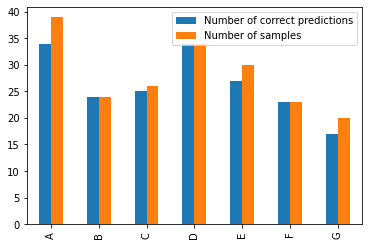

In [31]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [33]:
print(confusion_matrix(y_true, preds))

[[34  0  0  1  4  0  0]
 [ 0 24  0  0  0  0  0]
 [ 0  0 25  0  0  1  0]
 [ 0  0  0 34  0  0  0]
 [ 1  0  2  0 27  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  1  1  1  0  0 17]]


In [34]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.9387755102040817

In [35]:
with open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [36]:
precision = precision_score(y_true, preds, average=None)
precision

array([0.97142857, 0.96      , 0.89285714, 0.94444444, 0.87096774,
       0.95833333, 1.        ])

In [37]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.87179487, 1.        , 0.96153846, 1.        , 0.9       ,
       1.        , 0.85      ])

In [38]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.91891892, 0.97959184, 0.92592593, 0.97142857, 0.8852459 ,
       0.9787234 , 0.91891892])

In [39]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,0.971429,0.871795,0.918919
B,0.960000,1.000000,0.979592
C,0.892857,0.961538,0.925926
D,0.944444,1.000000,0.971429
E,0.870968,0.900000,0.885246
F,0.958333,1.000000,0.978723
G,1.000000,0.850000,0.918919


<AxesSubplot:>

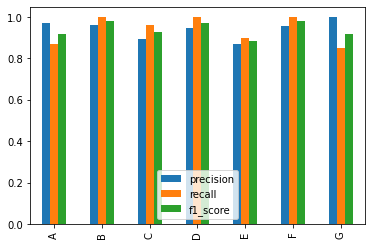

In [40]:
df.plot.bar()